# TP1 - Cloud Computing
## Aluno: Jean George Alves Evangelista
## Matrícula: 2024661178

## Initial setup

In [1]:
import matplotlib.pyplot as plt
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.getActiveSession()

# Load Spark if not loaded yet
if spark is None:
    spark = SparkSession.builder \
        .appName("HelloLines") \
        .config("spark.executor.instances", "2") \
        .config("spark.executor.cores", "2") \
        .config("spark.executor.memory", "1024M") \
        .getOrCreate()

24/11/19 21:25:53 WARN Utils: Your hostname, cloud1 resolves to a loopback address: 127.0.1.1; using 192.168.121.115 instead (on interface eth0)
24/11/19 21:25:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 21:25:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/19 21:25:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Load playlists dataframe
playlists_df = spark.read.json("hdfs://localhost:9000/tp1/playlist.json")

In [4]:
# Load tracks dataframe
tracks_df = spark.read.json("hdfs://localhost:9000/tp1/tracks.json")

## Task 1 - Statistics about songs duration

### Generate a table containing the minimum, average and maximum duration, in milliseconds, of the songs in the dataset.

In [5]:
statistics_table = tracks_df.select(
    F.min(tracks_df.duration_ms).alias("Minimum"),
    F.avg(tracks_df.duration_ms).alias("Average"),
    F.max(tracks_df.duration_ms).alias("Maximum")
)

statistics_table.show()

+-------+------------------+--------+
|Minimum|           Average| Maximum|
+-------+------------------+--------+
|      0|234408.54976216817|10435467|
+-------+------------------+--------+



### Compute the first and third quartiles (detoned <i>Q</i><sub>1</sub> and <i>Q</i><sub>3</sub>), as well as the [interquartile range (IRQ)](https://en.wikipedia.org/wiki/Interquartile_range) (<i>Q</i><sub>3</sub> - <i>Q</i><sub>1</sub>)

In [6]:
# Calculate the first and third quartile with `approxQuantile`
quartiles = tracks_df.approxQuantile("duration_ms", [0.25, 0.75], 0.01)
q1 = quartiles[0]
q3 = quartiles[1]

# Calculate the IRQ
irq = q3 - q1

# Create a data frame with the data and display
quartiles_df = spark.createDataFrame([[q1, q3, irq]], ["Q1", "Q3", "IRQ"])
quartiles_df.show()

+--------+--------+-------+
|      Q1|      Q3|    IRQ|
+--------+--------+-------+
|198026.0|258133.0|60107.0|
+--------+--------+-------+



### Compute the set of songs with durations that are not outliers, as defined by the [IQRR](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244) methodology. In other words, identify all songs with duration <i>x</i> such that <i>Q</i><sub>1</sub> - 1.5 × IQR < <i>x</i> < <i>Q</i><sub>3</sub> + 1.5 × IQR

In [7]:
# Create the defined constant
iqr_constant = 1.5 * irq

# Build the conditions
iqrr_condition_1 =  tracks_df.duration_ms > (q1 - iqr_constant)
iqrr_condition_2 =  tracks_df.duration_ms < (q3 + iqr_constant)

# Select the tracks that are not ouliers
tracks_without_outliers = tracks_df.where(iqrr_condition_1 & iqrr_condition_2)
tracks_without_outliers.show()

+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|duration_ms|pid|pos|          track_name|           track_uri|
+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|     226863|  0|  0|Lose Control (fea...|spotify:track:0Ua...|
|         In The Zone|spotify:album:0z7...|    Britney Spears|spotify:artist:26...|     198800|  0|  1|               Toxic|spotify:track:6I9...|
|Dangerously In Lo...|spotify:album:25h...|           Beyoncé|spotify:artist:6v...|     235933|  0|  2|       Crazy In Love|spotify:track:0Wq...|
|           Justified|spotify:album:6QP...| Justin Timberlake|spotify:artist:31...|     267266|  0|  3|      Rock Your Body|

### Using the IQRR methodology, how many songs would be considered outliers and removed from analysis? Generate a new table containing the minimum, average and maximum duration of the remaining songs.

In [8]:
total_number = tracks_df.count()
without_outliers_number = tracks_without_outliers.count()

outliers_number = total_number - without_outliers_number
print("Songs with outliers: " + str(total_number))
print("Songs without outliers: " + str(without_outliers_number))
print(str(outliers_number) + " songs would be considered outliers by using the IQRR methodology. ")

Songs with outliers: 10760544
Songs without outliers: 10189635
570909 songs would be considered outliers by using the IQRR methodology. 


In [9]:
statistics_table_without_outliners = tracks_without_outliers.select(
    F.min(tracks_without_outliers.duration_ms).alias("Minimum"),
    F.avg(tracks_without_outliers.duration_ms).alias("Average"),
    F.max(tracks_without_outliers.duration_ms).alias("Maximum")
)

print("Minimum, average and maximum duration of the remaining songs:")
statistics_table_without_outliners.show()

Minimum, average and maximum duration of the remaining songs:


+-------+-----------------+-------+
|Minimum|          Average|Maximum|
+-------+-----------------+-------+
| 107866|226795.8593433425| 348293|
+-------+-----------------+-------+



In [10]:
tracks_df = tracks_without_outliers

## Task 2 - Finding the most popular artists over time

### Find the five most popular artists ranked by the number of playlists they appear in

In [13]:
# Lets join the tracks with the playlists by `pid` (playlist id)
# This can be considered unnecessary, I am doing this just to make sure that every track is present in a valid playlist
tracks_with_playlists = tracks_df \
    .join(playlists_df, tracks_df.pid == playlists_df.pid, "inner") \
    .drop(tracks_df.pid) # Dropping one `pid` column, to avoid future issues

# To get 5 the most popular artists (by number of playlists) we need:
# 1 - Group by artist_uri & artist_name. Group by both can be considered unnecessary, but I am doing that to be more precise
# 2 - After group by artist, count by pid. This way we have the playlist number per artist
# 3 - Sort by count
# 4 - Limit to 5, to get the 5 most popular
most_popular_artists = tracks_with_playlists \
    .groupBy("artist_uri", "artist_name") \
    .agg(F.countDistinct("pid").alias("playlist_count")) \
    .sort(F.desc("playlist_count")) \
    .limit(5)

most_popular_artists.show()

24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:23 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+--------------+--------------+
|          artist_uri|   artist_name|playlist_count|
+--------------------+--------------+--------------+
|spotify:artist:3T...|         Drake|         31513|
|spotify:artist:5p...|       Rihanna|         23706|
|spotify:artist:5K...|    Kanye West|         21683|
|spotify:artist:1X...|    The Weeknd|         19648|
|spotify:artist:2Y...|Kendrick Lamar|         18222|
+--------------------+--------------+--------------+



### Create a chart that shows the number of playlists containing each of these five artists over the years. Consider that an artist is present in a playlist after each playlist's last modification date.

In [15]:
artists_per_year = tracks_with_playlists \
    .join(most_popular_artists, tracks_with_playlists.artist_uri == most_popular_artists.artist_uri, "inner") \
    .drop(most_popular_artists.artist_uri, most_popular_artists.artist_name) \
    .withColumn("year", F.year(F.from_unixtime("modified_at"))) \
    .groupBy("artist_name", "year") \
    .agg(F.countDistinct("pid").alias("playlist_number")) \
    .sort("year", "artist_name", "playlist_number") \

artists_per_year.show(artists_per_year.count())

24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:27:46 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------+----+---------------+
|   artist_name|year|playlist_number|
+--------------+----+---------------+
|    Kanye West|2011|              4|
|       Rihanna|2011|              1|
|         Drake|2012|             24|
|    Kanye West|2012|             20|
|Kendrick Lamar|2012|              4|
|       Rihanna|2012|             31|
|    The Weeknd|2012|              2|
|         Drake|2013|            490|
|    Kanye West|2013|            432|
|Kendrick Lamar|2013|            266|
|       Rihanna|2013|            498|
|    The Weeknd|2013|             93|
|         Drake|2014|            815|
|    Kanye West|2014|            774|
|Kendrick Lamar|2014|            428|
|       Rihanna|2014|            773|
|    The Weeknd|2014|            198|
|         Drake|2015|           2405|
|    Kanye West|2015|           1815|
|Kendrick Lamar|2015|           1209|
|       Rihanna|2015|           2021|
|    The Weeknd|2015|           2205|
|         Drake|2016|           7673|
|    Kanye W

In [16]:
# Data manipulation to plot the chart later
data = artists_per_year.collect()

plot_data = {}
for row in data:
    artist = row.artist_name
    year = row.year
    playlist_number = row.playlist_number
    if artist not in plot_data:
        plot_data[artist] = {}
    plot_data[artist][year] = playlist_number

print(plot_data)

24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:28:23 WARN RowBasedKeyValueBatch: Calling spill() on

{'Kanye West': {2011: 4, 2012: 20, 2013: 432, 2014: 774, 2015: 1815, 2016: 4949, 2017: 13689}, 'Rihanna': {2011: 1, 2012: 31, 2013: 498, 2014: 773, 2015: 2021, 2016: 5946, 2017: 14436}, 'Drake': {2012: 24, 2013: 490, 2014: 815, 2015: 2405, 2016: 7673, 2017: 20106}, 'Kendrick Lamar': {2012: 4, 2013: 266, 2014: 428, 2015: 1209, 2016: 2429, 2017: 13886}, 'The Weeknd': {2012: 2, 2013: 93, 2014: 198, 2015: 2205, 2016: 4311, 2017: 12839}}


In [17]:
# Getting an array of years to plot
unique_years = set()
for artist_data in plot_data.values():
    for year in artist_data:
        unique_years.add(year)

years = sorted(unique_years)

print(years)

[2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [18]:
artists = plot_data.keys()

print(artists)

dict_keys(['Kanye West', 'Rihanna', 'Drake', 'Kendrick Lamar', 'The Weeknd'])


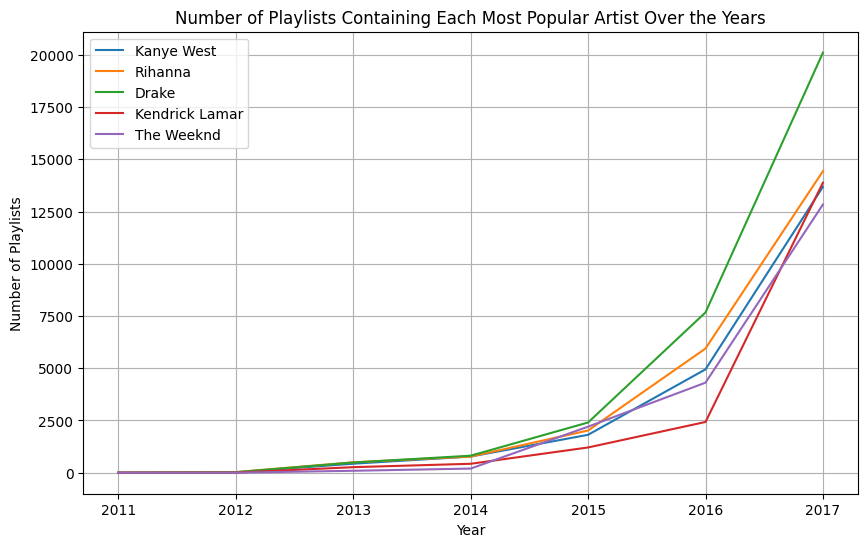

In [19]:
def plot_artist():
    for artist in artists:
        artist_data = []
        for year in years:
            value = plot_data[artist].get(year, 0)  # Get value for the year or default to 0
            artist_data.append(value)
        plt.plot(years, artist_data, label=artist)

plt.figure(figsize=(10, 6))
plot_artist()
plt.title("Number of Playlists Containing Each Most Popular Artist Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Playlists")
plt.legend()
plt.grid(True)
plt.show()

## Task 3 - Playlists's behavior

In [21]:
# First we need to group by playlist id and artist URI, count tracks for each artist
artist_counts = tracks_with_playlists \
    .groupBy("pid", "artist_uri") \
    .agg(F.count("track_uri").alias("track_count")
)

artist_counts.show()

+---+--------------------+-----------+
|pid|          artist_uri|track_count|
+---+--------------------+-----------+
|  0|spotify:artist:6v...|          2|
|  0|spotify:artist:2H...|          4|
|  3|spotify:artist:78...|          1|
| 11|spotify:artist:1H...|          1|
| 21|spotify:artist:3N...|          1|
| 32|spotify:artist:2y...|          1|
| 34|spotify:artist:0c...|          1|
| 48|spotify:artist:4x...|          1|
| 53|spotify:artist:3s...|          1|
| 53|spotify:artist:5K...|          1|
| 57|spotify:artist:3I...|          2|
| 63|spotify:artist:0U...|          1|
| 64|spotify:artist:4t...|          1|
| 83|spotify:artist:4o...|          1|
| 84|spotify:artist:6f...|          1|
| 86|spotify:artist:2h...|          1|
| 93|spotify:artist:1X...|          1|
| 95|spotify:artist:3n...|          1|
| 96|spotify:artist:26...|          5|
|106|spotify:artist:27...|          1|
+---+--------------------+-----------+
only showing top 20 rows



In [22]:
# Find the maximum track count for the most frequent artist in each playlist
most_frequent_artist = artist_counts \
    .groupBy("pid") \
    .agg(F.max("track_count").alias("max_track_count")
)

most_frequent_artist.show()

24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:29:23 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------------+
| pid|max_track_count|
+----+---------------+
|  26|              4|
|  29|              2|
| 964|              7|
|1677|              4|
|1697|              2|
|1806|              4|
|1950|              3|
|2040|              5|
|2214|              5|
|2250|              4|
|2453|             10|
|2509|              3|
|2529|              3|
|2927|              3|
|3091|              3|
|3506|              6|
|3764|              4|
|4590|             16|
|4823|              1|
|5385|              1|
+----+---------------+
only showing top 20 rows



In [24]:
# Calculate the total number of tracks for each playlist
playlist_total_tracks = tracks_with_playlists \
    .groupBy("pid") \
    .agg(F.count("track_uri").alias("total_tracks")
)

playlist_total_tracks.show()

+------+------------+
|   pid|total_tracks|
+------+------------+
|    26|          24|
|    29|          40|
|   474|          24|
|   964|         132|
|100031|          64|
|100501|         193|
|100565|          67|
|100847|          36|
|100852|         188|
|  1677|          27|
|  1697|          11|
|  1806|          89|
|  1950|          14|
|101011|          64|
|101067|          37|
|101155|          35|
|101221|          85|
|101333|          48|
|101496|          62|
|101507|          31|
+------+------------+
only showing top 20 rows



In [27]:
# Join with total tracks and calculate the prevalence (most frequent artist count / total tracks in the playlist)
prevalence_df = most_frequent_artist \
    .join(playlist_total_tracks, "pid") \
    .withColumn("prevalence", F.col("max_track_count") / F.col("total_tracks")
)

prevalence_df.show()

24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:05 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------------+------------+--------------------+
| pid|max_track_count|total_tracks|          prevalence|
+----+---------------+------------+--------------------+
|  26|              4|          24| 0.16666666666666666|
|  29|              2|          40|                0.05|
| 964|              7|         132| 0.05303030303030303|
|1677|              4|          27| 0.14814814814814814|
|1697|              2|          11| 0.18181818181818182|
|1806|              4|          89|  0.0449438202247191|
|1950|              3|          14| 0.21428571428571427|
|2040|              5|          50|                 0.1|
|2214|              5|          47| 0.10638297872340426|
|2250|              4|          65| 0.06153846153846154|
|2453|             10|         134| 0.07462686567164178|
|2509|              3|          45| 0.06666666666666667|
|2529|              3|          32|             0.09375|
|2927|              3|          23| 0.13043478260869565|
|3091|              3|         

In [28]:
# Collect the prevalence values for plot later
prevalence_values = prevalence_df \
    .select("prevalence") \
    .rdd \
    .flatMap(lambda x: x) \
    .collect()
prevalence_values = sorted(prevalence_values)

# Compute the CDF
cdf_values = []
n = len(prevalence_values)
for i in range(n):
    cumulative_probability = (i + 1) / n
    cdf_values.append(cumulative_probability)

24/11/19 21:30:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 21:30:21 WARN RowBasedKeyValueBatch: Calling spill() on

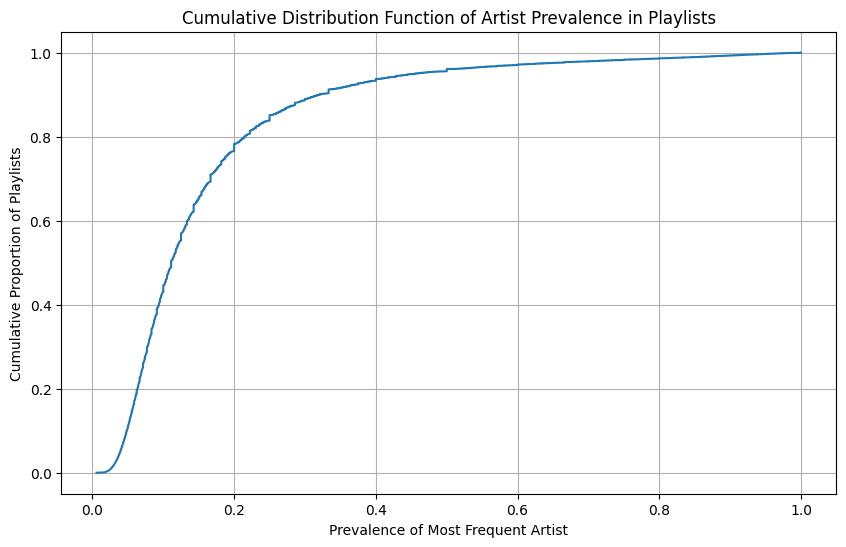

In [29]:
# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(prevalence_values, cdf_values)
plt.title("Cumulative Distribution Function of Artist Prevalence in Playlists")
plt.xlabel("Prevalence of Most Frequent Artist")
plt.ylabel("Cumulative Proportion of Playlists")
plt.grid()